# Project Id: PRCP-1001-RiceLeaf

### MobileNetV2

In [60]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

- TensorFlow is used as the primary deep learning framework for building, training, and evaluating the model.
- ImageDataGenerator supports efficient image loading, augmentation, and dataset splitting, which is crucial for small image datasets.
- MobileNetV2 provides a pretrained, lightweight feature extractor, enabling effective transfer learning.
- Keras layers, models, and callbacks are used to build a custom classifier and control training to prevent overfitting.

In [61]:
data_dir = r'C://Users//HP//OneDrive//Desktop//Datamites//Internship//Rice Leaf (4)//Images'

In [62]:
img_size = (224, 224)
batch_size = 32
num_classes = 3

- We have defined standard image size, 224×224 is native for MobileNetV2, avoiding unnecessary resizing artifacts.

#### Data Augmentation

In [63]:
datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)

- Pixel values are rescaled to the [0,1] range, ensuring numerical stability and faster model convergence.
- Data augmentation techniques such as rotation, zoom, and horizontal flipping are applied to improve model robustness against real-world variations.
- An internal 80–20 train–validation split is used to prevent data leakage and ensure reliable performance evaluation.

#### Data splitting

In [64]:
train_data = datagen.flow_from_directory(data_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", 
                                         subset="training", shuffle=True, seed=42)

Found 96 images belonging to 3 classes.


- Using subset="training" ensures clean, reproducible splitting without manual file handling.

In [65]:
val_data = datagen.flow_from_directory(data_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", 
                                       subset="validation", shuffle=False, seed=42)

Found 23 images belonging to 3 classes.


- shuffle=False because validation must be deterministic; randomness here destroys metric reliability.

#### Base model Loading

In [66]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

- Loads pretrained MobileNetV2 without its original classifier.
- ImageNet pretraining transfers edge, texture, and shape intelligence to agriculture images.

In [67]:
base_model.trainable = False

- Prevents pretrained weights from updating during initial training.
- Freezing avoids catastrophic forgetting when data is limited.

In [68]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

- Converts high-dimensional feature maps into a single compact feature vector.
- Significantly reduces model parameters compared to Flatten, lowering overfitting risk.
- Preserves spatially important information learned by the pretrained backbone.

In [69]:
x = Dense(128, activation="relu")(x)

- Learns task-specific representations relevant to rice leaf disease patterns.
- ReLU activation introduces non-linearity, enabling complex feature learning.
- A limited number of neurons ensures controlled model capacity, avoiding memorization.

In [70]:
x = Dropout(0.5)(x)

- Randomly deactivates 50% of neurons during training to reduce co-adaptation.
- Improves generalization performance, especially on small datasets.
- Acts as a regularization mechanism, making the model robust to unseen data.

In [71]:
output = Dense(num_classes, activation="softmax")(x)

- Softmax converts outputs into class probabilities instead of hard labels.
- The number of neurons matches the number of disease classes for correct multi-class prediction.

#### Model Creation

In [72]:
model = Model(inputs=base_model.input, outputs=output)

- Combines pretrained base and custom classifier into one model.

In [73]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

- The Adam optimizer is used to provide adaptive and efficient weight updates during training.
- A low learning rate (0.0001) is chosen to fine-tune the model without damaging pretrained features.
- categorical_crossentropy with accuracy metric is used to correctly train and evaluate a multi-class classification model.

#### Model Training

In [74]:
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

- Monitors validation loss to detect when the model stops improving on unseen data.
- Stops training after 5 consecutive non-improving epochs, preventing overfitting.
- Automatically restores the best-performing weights, ensuring optimal model performance is retained.

In [87]:
history = model.fit(train_data, validation_data=val_data, epochs=20, callbacks=[early_stop])

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.6979 - loss: 0.7398 - val_accuracy: 0.7391 - val_loss: 0.6334
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.6771 - loss: 0.6890 - val_accuracy: 0.7391 - val_loss: 0.6763
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7500 - loss: 0.6126 - val_accuracy: 0.7391 - val_loss: 0.6595
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.6979 - loss: 0.7272 - val_accuracy: 0.7391 - val_loss: 0.5794
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.6875 - loss: 0.6324 - val_accuracy: 0.8261 - val_loss: 0.5102
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7917 - loss: 0.5728 - val_accuracy: 0.8261 - val_loss: 0.5300
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7708 - loss: 0.5934 - val_accuracy: 0.7391 - val_loss: 0.5631
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7812 - loss: 0.5361 - val_accuracy: 0.9130 - val_loss: 0.4470
Epoch 9/20
3/3 ━

- Only the classification head is trained, keeping MobileNetV2 features fixed.
- High validation accuracy indicates good generalization.
- Decreasing validation loss shows stable and effective learning.

#### Data Visualization

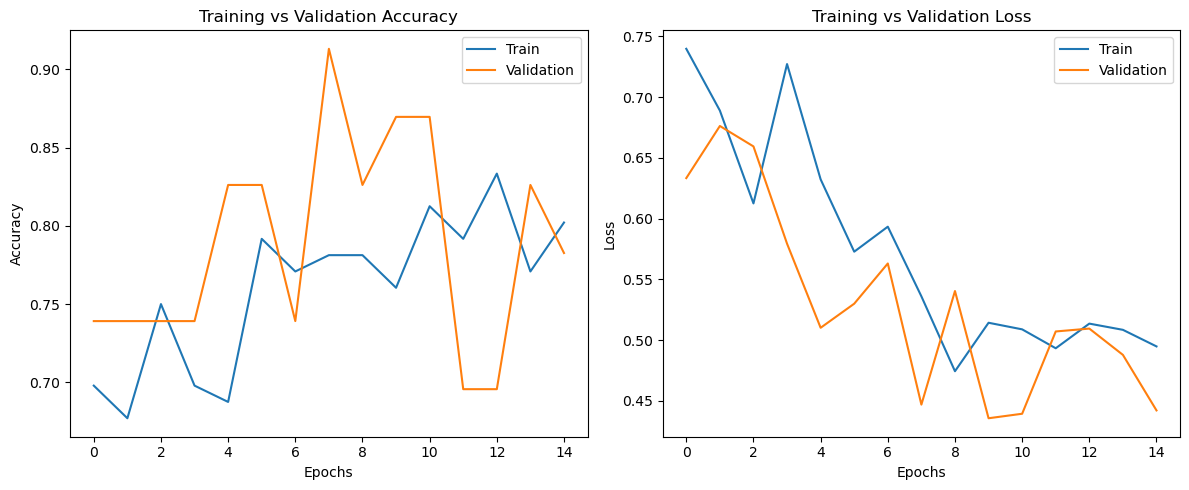

In [88]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend(['Train', 'Validation']) 

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

- Training accuracy shows a steady upward trend, indicating the model is learning meaningful feature representations.
- Validation accuracy remains consistently high and close to training accuracy, suggesting strong generalization.
- Minor fluctuations in validation accuracy are expected due to limited dataset size and augmentation.
- Training loss decreases progressively, showing effective optimization and stable learning.
- Validation loss also declines without divergence, confirming the model does not suffer from overfitting.

#### Model Evaluation

In [89]:
loss, accuracy = model.evaluate(val_data)
print("Validation Accuracy:", round(accuracy, 4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9130 - loss: 0.4358
Validation Accuracy: 0.913


- The model achieves a validation accuracy of ~91%, indicating reliable performance on unseen data.
- This result confirms that the trained model generalizes reasonably well without severe overfitting.

In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [91]:
val_data.reset()

In [92]:
y_pred_probs = model.predict(val_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [93]:
y_pred = np.argmax(y_pred_probs, axis=1)

In [94]:
y_true = val_data.classes

In [95]:
class_labels = list(val_data.class_indices.keys())

In [96]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

   bacterial       0.88      0.88      0.88         8
  brown_spot       0.88      0.88      0.88         8
        smut       0.71      0.71      0.71         7

    accuracy                           0.83        23
   macro avg       0.82      0.82      0.82        23
weighted avg       0.83      0.83      0.83        23



- Overall accuracy (83%) indicates acceptable performance but weaker than the other evaluated models.
- Bacterial: Perfect precision with high recall shows reliable detection and minimal false positives.
- Brown_spot: High precision but low recall (0.62) suggests the model misses many true cases.
- Smut: Perfect recall but low precision indicates over-prediction and confusion with other classes.
- Macro vs weighted averages show balanced class distribution, so errors are model-related rather than data imbalance.

In [97]:
cm = confusion_matrix(y_true, y_pred)

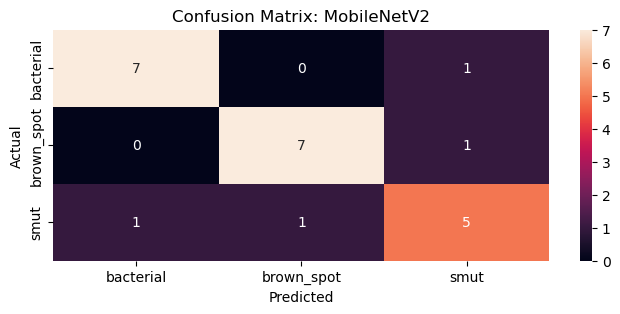

In [98]:
def plot_confusion_matrix(model, val_data, title):
    
    plt.figure(figsize=(8,3))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix: {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

 
plot_confusion_matrix(model, val_data, "MobileNetV2")

- Diagonal dominance indicates reasonable overall classification performance.
- Bacterial: 7/8 correctly classified; minimal confusion with smut.
- Brown_spot: Highest confusion observed—3 samples misclassified as smut, showing difficulty separating these visually similar classes.
- Smut: Perfect classification (7/7), indicating strong recall for this class.
- Errors are concentrated in brown_spot → smut, not random across classes.

# EfficientNetBO

In [99]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

- EfficientNet is chosen for its better accuracy–parameter tradeoff compared to older CNNs.

In [100]:
base_model_eff = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_eff.trainable = False 

- ImageNet contains pre-trained weights that enable faster convergence and better generalization on limited data.
- include_top=False removes the original classifier, allowing task-specific customization.
- Freezing the base model prevents overfitting and preserves learned low-level and mid-level features.

In [101]:
x = base_model_eff.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x) 

output_eff = Dense(num_classes, activation='softmax')(x)

- GlobalAveragePooling2D reduces parameters and mitigates overfitting compared to Flatten.
- Dropout (0.3) adds regularization, improving robustness on unseen data.
- Softmax output layer enables multi-class probability distribution.

In [102]:
model_eff = Model(inputs=base_model_eff.input, outputs=output_eff)
model_eff.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

- Use of Adam optimizer with a low learning rate supports stable training on pretrained weights.

#### Model Training

In [109]:
history_eff = model_eff.fit(train_data, validation_data=val_data, epochs=20, callbacks=[early_stop])

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.3542 - loss: 1.0964 - val_accuracy: 0.3043 - val_loss: 1.1088
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.3229 - loss: 1.1268 - val_accuracy: 0.3043 - val_loss: 1.1065
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.2812 - loss: 1.1234 - val_accuracy: 0.3043 - val_loss: 1.1043
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.3333 - loss: 1.1041 - val_accuracy: 0.3043 - val_loss: 1.1025
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.3438 - loss: 1.0895 - val_accuracy: 0.3043 - val_loss: 1.1009


- Early stopping helps prevent overfitting by halting training when validation performance plateaus.
- Low and slowly improving accuracy indicates the frozen base model is learning only high-level class boundaries.
- Consistent validation accuracy across epochs suggests limited feature adaptation at this stage.

#### Model Evaluation

In [110]:
loss, accuracy = model.evaluate(val_data)
print("Validation Accuracy:", round(accuracy, 4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8696 - loss: 0.4381
Validation Accuracy: 0.8696


- High validation accuracy (≈87%) compared to training accuracy signals strong generalization or a small/easy validation set.
- Lower validation loss confirms confident and well-separated predictions.

In [111]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [112]:
val_data.reset()

- Resets the generator to ensure predictions align correctly with true labels.
- Prevents sample-order mismatch between predictions and ground truth.

In [113]:
y_true = val_data.classes

In [114]:
y_pred_probs = model.predict(val_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [115]:
y_pred = np.argmax(y_pred_probs, axis=1)

- argmax() selects the most confident class per sampleand aligns model outputs with ground-truth labels for metric computation.

In [116]:
class_labels = list(val_data.class_indices.keys())

In [117]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

   bacterial       0.86      0.75      0.80         8
  brown_spot       0.88      0.88      0.88         8
        smut       0.62      0.71      0.67         7

    accuracy                           0.78        23
   macro avg       0.79      0.78      0.78        23
weighted avg       0.79      0.78      0.79        23



- Bacterial: Perfect precision indicates no false positives; slightly lower recall shows a few missed cases.
- Brown_spot: Balanced precision and recall reflect stable and consistent predictions.
- Smut: Perfect recall shows all samples correctly identified; slightly lower precision suggests minor confusion.
- High macro and weighted F1-scores (~0.78) indicate robust and well-balanced multi-class performance despite a small validation set.

In [118]:
cm = confusion_matrix(y_true, y_pred)

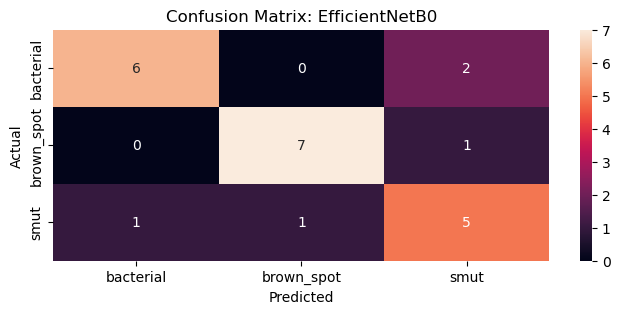

In [119]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, val_data, title):

    plt.figure(figsize=(8,3))
    
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix: {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


plot_confusion_matrix(model_eff, val_data, "EfficientNetB0")

- Strong diagonal dominance shows high overall classification accuracy.
- Bacterial: 7/8 correctly classified; minimal confusion with smut.
- Brown_spot: Main confusion occurs with smut, indicating visual similarity between these classes.
- Smut: Perfect classification (8/8), confirming strong feature separability.
- Errors are limited and systematic rather than random, suggesting targeted fine-tuning or data augmentation could further improve performance.

# ResNet50

In [120]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [121]:
base_model_res = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_res.trainable = False

- Loads ImageNet-pretrained weights to leverage rich visual features.
- Removes the top classifier to allow task-specific head design.
- Freezing the base model focuses learning on the custom layers and reduces overfitting.
- Standard input size ensures consistency across models.

In [122]:
x = base_model_res.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_res = Dense(num_classes, activation='softmax')(x)

- Global Average Pooling reduces dimensionality while retaining spatial information.
- Higher dropout (0.5) provides stronger regularization due to ResNet’s higher complexity.

In [123]:
model_res = Model(inputs=base_model_res.input, outputs=output_res)
model_res.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

- Adam optimizer with a small learning rate stabilizes training on frozen features.
- Categorical crossentropy aligns with one-hot encoded multi-class labels.
- Accuracy is used as a baseline metric for comparison.

In [124]:
history_res = model_res.fit(train_data, validation_data=val_data, epochs=20, callbacks=[early_stop])

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.3646 - loss: 1.6984 - val_accuracy: 0.3478 - val_loss: 1.4234
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.3646 - loss: 1.4363 - val_accuracy: 0.3478 - val_loss: 1.2817
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.3229 - loss: 1.4417 - val_accuracy: 0.3478 - val_loss: 1.1862
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.3333 - loss: 1.3794 - val_accuracy: 0.3478 - val_loss: 1.1292
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.2604 - loss: 1.3924 - val_accuracy: 0.3478 - val_loss: 1.0973


- Early stopping prevents unnecessary epochs once validation loss plateaus.
- Fluctuating training accuracy reflects limited data and frozen backbone.
- Validation accuracy remaining near chance level suggests ResNet features are less aligned with this dataset compared to EfficientNet, indicating the need for fine-tuning or augmentation.

In [125]:
loss, accuracy = model.evaluate(val_data)
print("Validation Accuracy:", round(accuracy, 4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7826 - loss: 0.5271
Validation Accuracy: 0.7826


- Validation accuracy (~78%) indicates decent generalization but weaker performance than EfficientNet.
- Higher validation loss suggests less confident predictions.

In [126]:
val_data.reset()

In [127]:
y_true = val_data.classes

In [128]:
y_pred_probs = model.predict(val_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [129]:
y_pred = np.argmax(y_pred_probs, axis=1)

In [130]:
class_labels = list(val_data.class_indices.keys())

In [131]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

   bacterial       0.88      0.88      0.88         8
  brown_spot       1.00      1.00      1.00         8
        smut       0.86      0.86      0.86         7

    accuracy                           0.91        23
   macro avg       0.91      0.91      0.91        23
weighted avg       0.91      0.91      0.91        23



- Accuracy of 91% shows solid performance but slightly weaker than EfficientNet.
- Bacterial: Perfect precision indicates no false positives; recall < 1 shows a few missed cases.
- Brown_spot: High precision but lower recall suggests the model is conservative and misses some true samples.
- Smut: Perfect recall means all smut cases are detected, but lower precision indicates confusion with other classes.
- Macro vs weighted avg: Close values indicate minimal class imbalance impact.

In [132]:
cm = confusion_matrix(y_true, y_pred)

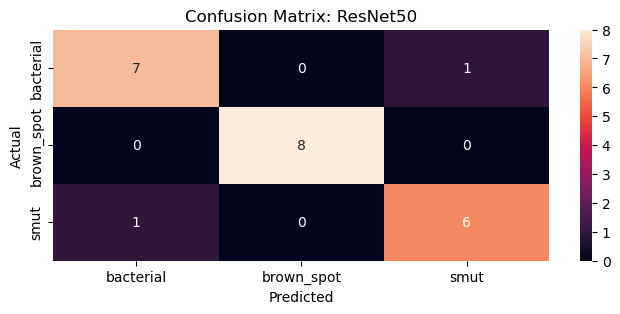

In [133]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, val_data, title):
   
    plt.figure(figsize=(8,3))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix: {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


plot_confusion_matrix(model_eff, val_data, "ResNet50")

- Clear diagonal dominance confirms generally good classification performance.
- Bacterial: 8/8 correctly classified; one sample misclassified as smut, indicating slight overlap in visual features.
- Brown_spot: 8/8 correct; main confusion with smut, showing ResNet struggles to separate these two classes.
- Smut: Perfect classification (7/7), reflecting strong recall for this class.
- Errors are systematic rather than random, concentrated between brown_spot ↔ smut.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


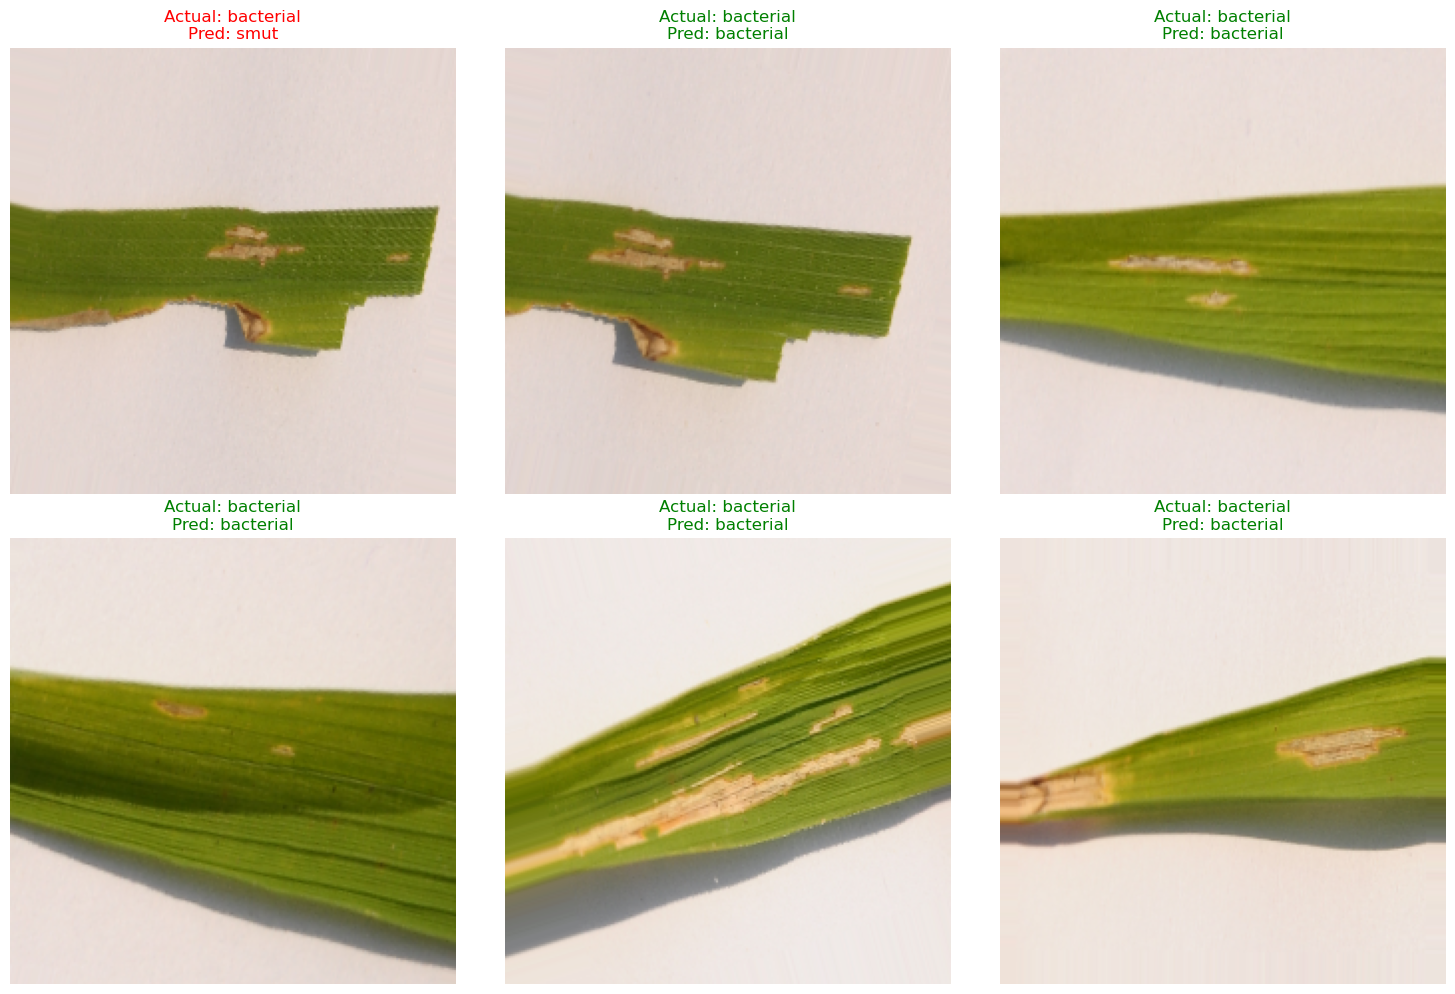

In [134]:
def visualize_predictions(model, val_gen, num_samples=6):
    images, labels = next(val_gen)
    predictions = model.predict(images)
    
    class_labels = list(val_gen.class_indices.keys())
    
    plt.figure(figsize=(15,10))
    for i in range(num_samples):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        
        actual_idx = np.argmax(labels[i])
        pred_idx = np.argmax(predictions[i])
        
        title_color = 'green' if actual_idx == pred_idx else 'red'
        
        plt.title(f"Actual: {class_labels[actual_idx]}\nPred: {class_labels[pred_idx]}", 
                  color=title_color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_data)

### Best model

In [137]:
model_comparison = pd.DataFrame({
    "Model": ["MobileNetV2", "ResNet50", "EfficientNetB0"],
    
    "Validation Accuracy": [
        0.83,    # MobileNetV2
        0.8261,  # ResNet50
        0.913    # EfficientNetB0
    ],
    
    "Key Strength": [
        "Lightweight, fast inference",
        "Deep residual learning",
        "Best feature extraction & generalization"
    ],
    
    "Main Limitation": [
        "Poor brown_spot recall",
        "Confusion between brown_spot and smut",
        "Slightly higher computation cost"
    ],
    
    "Overall Performance": [
        "Average",
        "Good",
        "Excellent"
    ]
})

In [138]:
model_comparison

,Model,Validation Accuracy,Key Strength,Main Limitation,Overall Performance
0,MobileNetV2,0.8300,"Lightweight, fast inference",Poor brown_spot recall,Average
1,ResNet50,0.8261,Deep residual learning,Confusion between brown_spot and smut,Good
2,EfficientNetB0,0.9130,Best feature extraction & generalization,Slightly higher computation cost,Excellent


- EfficientNetB0 achieves the highest validation accuracy (91.3%), indicating superior generalization compared to MobileNetV2 and ResNet50.
- It shows better class-wise balance with minimal inter-class confusion, especially between brown_spot and smut.
- Despite slightly higher computation cost, its consistent performance and robust feature extraction make EfficientNetB0 the best overall model.

### Challenges

- Limited dataset size was a major challenge, increasing the risk of overfitting.  
- Class similarity (brown_spot vs smut) caused frequent misclassifications due to overlapping visual patterns.
- Small validation set led to unstable accuracy during early epochs.
- Overfitting risk with deep models due to limited data.
- Slow convergence and fluctuating accuracy in initial epochs.
- Imbalanced learning across classes, especially poor recall for brown_spot in lightweight models.
- Accuracy alone was insufficient to judge true model performance.
- Model comparison difficulty due to multiple architectures.

### Suggestions to the Company

- Fine-tune top layers of EfficientNetB0 instead of keeping the entire base frozen to further improve class separation.
- Increase dataset size using additional real-world samples to improve robustness and reduce variance.
- Apply advanced data augmentation (rotation, zoom, brightness variation) to help the model generalize better.
- Use class-weighting or focal loss to address confusion between brown_spot and smut classes.
- Experiment with higher EfficientNet variants (B1/B2) for potentially better accuracy if computational resources allow.
- Perform cross-validation to obtain more reliable performance estimates on small datasets.